In [1]:
import xarray as xr
import numpy as np
import os

In the notebook EDA.ipynb, it was determined that some of the variables in the dataset were highly correlated with each other, namely the surface mass concentration (SMASS) variables. As such, those will be dropped before any further analysis. Additionally, DUCMASS and DUCMASS25, as well as SSCMASS and SSSMASS25, were found to be highly correlated, so only DUCMASS and SSCMASS will be kept.

In [2]:
ds = xr.open_dataset('/home/giantstep5/rjones98/meteorology/ESS569/ai_ready/AI_ready_dataset.nc')
ds = ds.drop_vars(['BCSMASS', 'DUCMASS25', 'DUSMASS', 'DUSMASS25', 'OCSMASS', 'SO2SMASS', 'SO4SMASS', 'SSCMASS25', 'SSSMASS', 'SSSMASS25', 'energy'])
ds

<xarray.Dataset>
Dimensions:        (time: 2920, lat: 52, lon: 94)
Coordinates:
  * lat            (lat) float64 24.5 25.0 25.5 26.0 ... 48.5 49.0 49.5 50.0
  * lon            (lon) float64 -125.0 -124.4 -123.8 ... -68.12 -67.5 -66.88
  * time           (time) datetime64[ns] 2023-01-01 ... 2023-12-31T21:00:00
Data variables:
    cape           (time, lat, lon) float64 ...
    precipitation  (time, lat, lon) float32 ...
    BCCMASS        (time, lat, lon) float32 ...
    DUCMASS        (time, lat, lon) float32 ...
    OCCMASS        (time, lat, lon) float32 ...
    SO2CMASS       (time, lat, lon) float32 ...
    SO4CMASS       (time, lat, lon) float32 ...
    SSCMASS        (time, lat, lon) float32 ...
    ltg            (time, lat, lon) float64 ...
Attributes:
    regrid_method:  conservative

In [3]:
df = ds.to_dataframe().reset_index()
df_jan = df.head(1212224)
df_jan.head()

,time,lat,lon,cape,precipitation,BCCMASS,DUCMASS,OCCMASS,SO2CMASS,SO4CMASS,SSCMASS,ltg
0,2023-01-01,24.5,-125.000,9.550140e-13,0.0,2.505434e-07,0.000001,9.709565e-07,1.464562e-07,0.000001,0.000008,0.0
1,2023-01-01,24.5,-124.375,1.126244e-01,0.0,2.501359e-07,0.000001,9.646701e-07,1.444383e-07,0.000001,0.000007,0.0
2,2023-01-01,24.5,-123.750,2.252488e-01,0.0,2.515717e-07,0.000001,9.645149e-07,1.418384e-07,0.000001,0.000006,0.0
3,2023-01-01,24.5,-123.125,2.778068e-01,0.0,2.527164e-07,0.000001,9.641268e-07,1.414309e-07,0.000001,0.000005,0.0
4,2023-01-01,24.5,-122.500,6.719603e-01,0.0,2.522120e-07,0.000001,9.604015e-07,1.408294e-07,0.000001,0.000004,0.0


# Cross-validation, Train-val-test splitting, and performance generality

In the notebook AutoML_Hyperparameter_Tuning.ipynb, it was discovered that the Extra Trees Regressor and the Light Gradient Boosting Machine from PyCaret were the best performing models of the ones included in the package. As such, those are the model that will be used throughout this notebook.

Below, a train-val-test split is performed on the data, with 80% of the data used for training, 20% used for testingAdditionally, 10-fold cross validation is used, which helps robustly assess performance.

Using the 10-fold cross validation implements performance generality, as the data is being subset when the model is run, and one set is being used for validation while the others are used for training. Since one set is being set aside for validation using this method, a validation split is not done before the model is run.

In [4]:
from sklearn.model_selection import train_test_split
from pycaret.regression import setup, create_model, finalize_model, predict_model, evaluate_model

train_data, test_data = train_test_split(df_jan, test_size=0.2, random_state=42)

regression_setup = setup(
    data=train_data,      
    target='ltg',         
    fold_strategy='kfold', # Cross-validation strategy
    fold=10,              # Number of folds
    session_id=123,       
    normalize=True,
)

et_model = create_model('et')
final_et_model = finalize_model(et_model)
lgbm_model = create_model('lightgbm')
final_lgbm_model = finalize_model(lgbm_model)

test_et_predictions = predict_model(final_et_model, data=test_data)
test_lgbm_predictions = predict_model(final_lgbm_model, data=test_data)

,Description,Value
0,Session id,123
1,Target,ltg
2,Target type,Regression
3,Original data shape,"(969779, 12)"
4,Transformed data shape,"(969779, 14)"
5,Transformed train set shape,"(678845, 14)"
6,Transformed test set shape,"(290934, 14)"
7,Numeric features,10
8,Date features,1
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0004,0.0001,0.0084,0.5337,0.0063,8.5854
1,0.0004,0.0001,0.0076,0.7055,0.0058,9.5956
2,0.0004,0.0001,0.0075,0.6492,0.0058,9.8355
3,0.0004,0.0001,0.0077,0.5405,0.0060,12.7979
4,0.0005,0.0001,0.0098,0.5287,0.0068,8.9409
5,0.0005,0.0001,0.0102,0.4732,0.0073,8.6748
6,0.0004,0.0000,0.0066,0.5857,0.0053,9.4280
7,0.0004,0.0001,0.0075,0.6053,0.0057,7.4728
8,0.0004,0.0001,0.0089,0.4997,0.0068,8.3010


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0004,0.0001,0.0085,0.5215,0.0064,7.5401
1,0.0004,0.0001,0.0078,0.6871,0.0058,8.6043
2,0.0004,0.0001,0.0076,0.6388,0.0060,8.3912
3,0.0004,0.0001,0.0084,0.4557,0.0064,8.9266
4,0.0005,0.0001,0.0105,0.4566,0.0074,6.0889
5,0.0005,0.0001,0.0102,0.4704,0.0072,7.2094
6,0.0004,0.0000,0.0069,0.5425,0.0055,7.2353
7,0.0004,0.0001,0.0078,0.5692,0.0060,8.1622
8,0.0005,0.0001,0.0090,0.4817,0.0069,7.3548


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0004,0.0001,0.0084,0.5793,0.0061,7.6625


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0004,0.0001,0.0081,0.6012,0.0059,7.0206


In [5]:
test_et_predictions

,time,lat,lon,cape,precipitation,BCCMASS,DUCMASS,OCCMASS,SO2CMASS,SO4CMASS,SSCMASS,ltg,prediction_label
1138121,2023-01-30 00:00:00,46.0,-85.625,6.990461e-01,0.000000,3.430766e-07,0.000006,1.182873e-06,1.517708e-06,0.000002,7.331886e-06,0.0,0.0
460872,2023-01-12 18:00:00,31.5,-72.500,1.818989e-12,0.000000,2.588223e-07,0.000004,7.526815e-07,1.134826e-06,0.000002,8.881154e-06,0.0,0.0
283493,2023-01-08 03:00:00,50.0,-73.125,8.039387e-01,0.000000,2.228351e-07,0.000002,9.107250e-07,3.468844e-07,0.000001,1.211348e-06,0.0,0.0
1153683,2023-01-30 12:00:00,25.0,-111.875,1.818989e-12,0.000000,3.245019e-07,0.000005,1.561664e-06,3.957606e-07,0.000003,8.135315e-06,0.0,0.0
803633,2023-01-21 12:00:00,35.0,-108.125,5.633873e-02,0.000000,3.974296e-07,0.000009,1.661632e-06,2.873139e-06,0.000004,9.002562e-07,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343034,2023-01-09 18:00:00,29.0,-107.500,1.818989e-12,0.000000,7.247359e-07,0.000002,1.235568e-05,1.322647e-06,0.000001,1.906826e-07,0.0,0.0
676345,2023-01-18 06:00:00,34.0,-115.625,1.818989e-12,0.000000,4.348071e-07,0.000013,1.503087e-06,2.116881e-06,0.000003,1.272386e-06,0.0,0.0
569483,2023-01-15 12:00:00,37.5,-105.625,2.004778e+00,0.000504,2.655182e-07,0.000004,1.627745e-06,5.937359e-07,0.000001,1.797905e-06,0.0,0.0
9537,2023-01-01 03:00:00,49.0,-98.125,1.231336e+00,0.000000,6.437649e-07,0.000005,1.664727e-06,1.713821e-06,0.000004,8.470415e-07,0.0,0.0


In [6]:
test_lgbm_predictions

,time,lat,lon,cape,precipitation,BCCMASS,DUCMASS,OCCMASS,SO2CMASS,SO4CMASS,SSCMASS,ltg,prediction_label
1138121,2023-01-30 00:00:00,46.0,-85.625,6.990461e-01,0.000000,3.430766e-07,0.000006,1.182873e-06,1.517708e-06,0.000002,7.331886e-06,0.0,-8.132146e-07
460872,2023-01-12 18:00:00,31.5,-72.500,1.818989e-12,0.000000,2.588223e-07,0.000004,7.526815e-07,1.134826e-06,0.000002,8.881154e-06,0.0,5.354801e-06
283493,2023-01-08 03:00:00,50.0,-73.125,8.039387e-01,0.000000,2.228351e-07,0.000002,9.107250e-07,3.468844e-07,0.000001,1.211348e-06,0.0,5.354801e-06
1153683,2023-01-30 12:00:00,25.0,-111.875,1.818989e-12,0.000000,3.245019e-07,0.000005,1.561664e-06,3.957606e-07,0.000003,8.135315e-06,0.0,-1.217426e-06
803633,2023-01-21 12:00:00,35.0,-108.125,5.633873e-02,0.000000,3.974296e-07,0.000009,1.661632e-06,2.873139e-06,0.000004,9.002562e-07,0.0,-1.217426e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343034,2023-01-09 18:00:00,29.0,-107.500,1.818989e-12,0.000000,7.247359e-07,0.000002,1.235568e-05,1.322647e-06,0.000001,1.906826e-07,0.0,4.950590e-06
676345,2023-01-18 06:00:00,34.0,-115.625,1.818989e-12,0.000000,4.348071e-07,0.000013,1.503087e-06,2.116881e-06,0.000003,1.272386e-06,0.0,-1.217426e-06
569483,2023-01-15 12:00:00,37.5,-105.625,2.004778e+00,0.000504,2.655182e-07,0.000004,1.627745e-06,5.937359e-07,0.000001,1.797905e-06,0.0,1.442142e-06
9537,2023-01-01 03:00:00,49.0,-98.125,1.231336e+00,0.000000,6.437649e-07,0.000005,1.664727e-06,1.713821e-06,0.000004,8.470415e-07,0.0,4.950590e-06


# Bootstrapping and Bagging

The Extra Trees Regressor uses a form of bootstrapping, similar to how a Random Forest does. The Extra Trees Regressor performs bootstrapping to create different subsets of the training data, each of which are used to train different decision trees. The key difference between the Extra Trees Regressor and the Random Forest is that the Extra Trees Regressor randomly picks split points for each feature.

In [7]:
train_data.columns.tolist()

['time',
 'lat',
 'lon',
 'cape',
 'precipitation',
 'BCCMASS',
 'DUCMASS',
 'OCCMASS',
 'SO2CMASS',
 'SO4CMASS',
 'SSCMASS',
 'ltg']

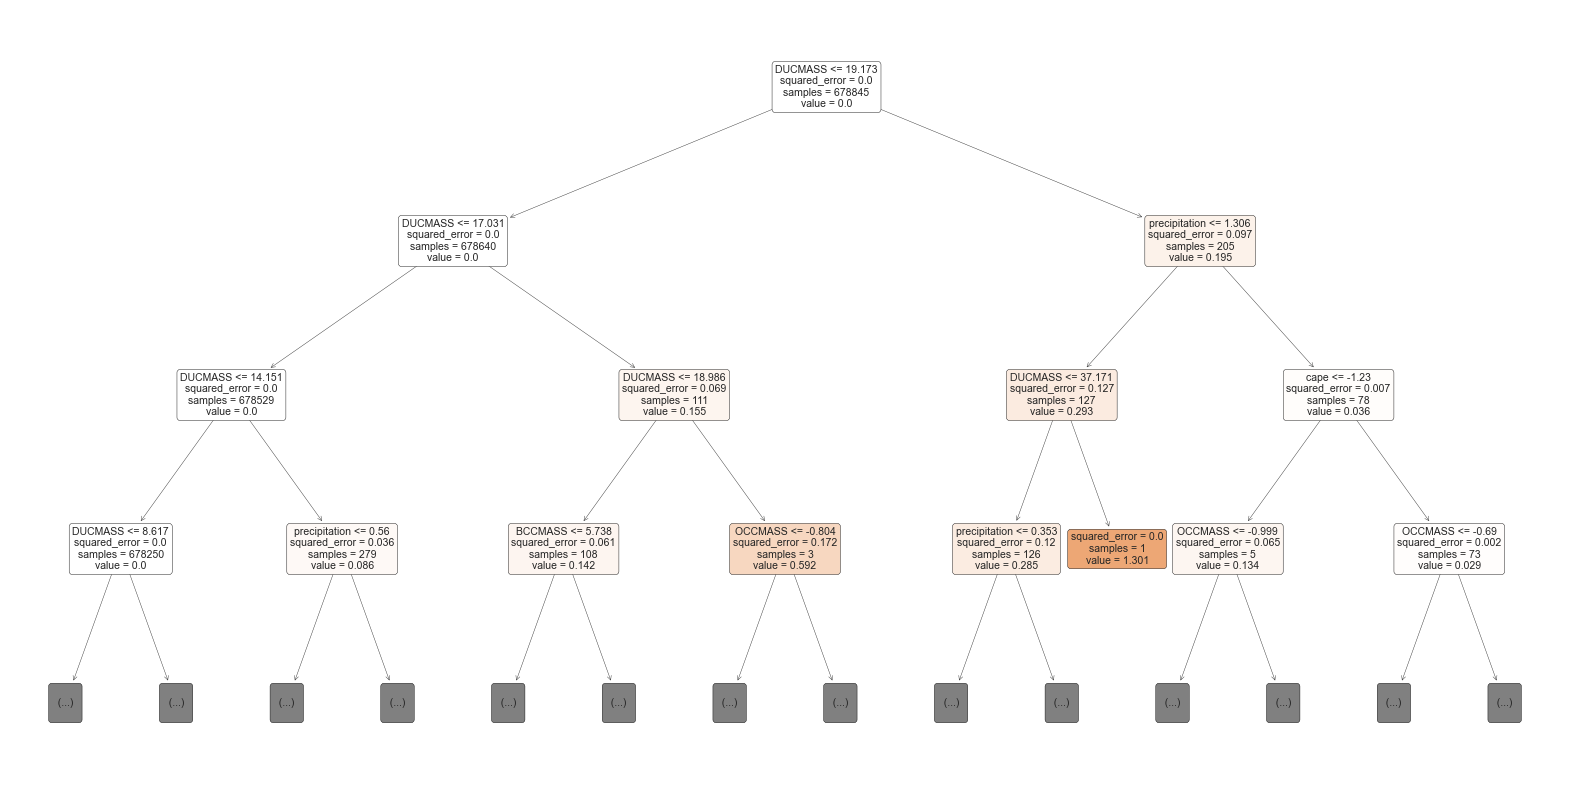

In [8]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualizing the first tree in the ensemble
tree = et_model.estimators_[0]  # Get the first tree from the ensemble

plt.figure(figsize=(20, 10))  # You can adjust the size to fit your tree
plot_tree(tree, filled=True, feature_names=train_data.columns.tolist(), rounded=True, max_depth=3)
plt.show()


# Visualizing Model Performance

PyCaret's evaluate_model feature contains built-in features for visualizing model performance, such as feature performance, a learning vurve, a validation curve and decision tree. These will be shown and discussed below.

In [9]:
evaluate_model(final_et_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [10]:
evaluate_model(final_et_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [11]:
evaluate_model(final_et_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [12]:
evaluate_model(final_lgbm_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [13]:
evaluate_model(final_lgbm_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [14]:
evaluate_model(final_lgbm_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

For regression problems, PyCaret's default score used is the R$^2$ score. In the learning curves for both the Extra Trees Regressor and the Light Gradient Boosting Machine, the R$^2$ score for the training is high while the cross validation score is low, but improves with increased training instances. Typically, this would indicate overfitting, as an overfit model has much higher R$^2$ values for training than cross-validation. However, when attempting to predict lighting or other rare events, this behavior is typical, as it is hard to generalize patterns to unseen data when the data trained on is very sporadic. 

Similar to the learning curve, the default score used for the valuation curve in PyCaret is the R$^2$ score. There is large disagreement between the training and cross-validation curves for the valuation scores as well, although the values are closer and much more gradual in the Extra Trees Regressor than in the Light Gradient Boosting Machine. A max depth of 2 when looking at the Light Gradient Boosting Machine returns the same R$^2$ value as a max depth of 4 when looking at the Extra Trees Regressor. This suggests that the Light Gradient Boosting Machine is able to learn the main patters of the data quicker than the Extra Trees Regressor is. However, the cross validation scores in both the Extra Trees Regressor and the Light Gradient Boosting Machine begin to plateau rather quickly, meaning that not much can be learned in the later stages of training. This suggests that time could be saved by stopping training early, as not much is gained from the additional depth.

With regards to feature importance, CAPE and precipitation are found to be quite important, which makes sense as the product of the two is a common lightning parameterization. CAPE is found to be the most important variable in the Extra Trees Regressor, while it ranks fifth in the Light Gradient Boosting Machine. CAPE, a measure of atmospheric instability, and time of day typically co-vary, as the largest CAPE values are typically seen in the late afternoon after the surface has been heated for long periods of time, leading to greater instability. As such, the importance given to time of day may actually be attributable to CAPE. Latitude is determined to be more important than longitude in both models, which is interesting due to the differences in the amount of lightning east and west of the Rocky Mountains. The order of the aerosol concentrations in the two models is the same for the two most important aerosols (sea salt and sulfur dioxide), but the order of the remaining four concentrations is reversed in the two models. Month and year have no importance, as all data used in this notebook is from the same month and same year.